In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\valer\AppData\Local\Temp\ipykernel_25148\3632437423.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('sale_tasks_dataset.csv', decimal='.')
df.head(5)

,customer_id,age,gender_cd,region_size,foreign_flg,entrepreneur_flg,auto_flg,traveler_flg,partnership_flg,child_amt,...,state_talk_time_sec,wo_hit_status_result_desc,wo_hit_status_reason_desc,employee_id,emp_age,emp_gender_cd,emp_children_cnt,emp_work_months_cnt,emp_citizenship_country_cd,emp_marital_status_cd
0,422206773,58.0,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,67.0,"Дозвон, Отказ",Перезвонит самостоятельно позднее,142052.0,30,W,NaN,1,NaN,NaN
1,348648289,44.0,M,rural,0.0,0.0,0.0,0.0,1.0,1.0,...,151.0,"Дозвон, Отказ",Другое,7004.0,36,W,NaN,2,RUS,NaN
2,345496995,23.0,F,town,0.0,0.0,1.0,0.0,1.0,0.0,...,68.0,"Дозвон, Успешно",Назначена встреча,80760.0,52,W,NaN,6,NaN,NaN
3,182783192,34.0,M,town,0.0,0.0,0.0,0.0,0.0,0.0,...,738.0,"Дозвон, Успешно",Обещал утилизироваться самостоятельно,158672.0,22,NaN,NaN,8,NaN,NaN
4,138498254,30.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.0,"Дозвон, Отказ",Переведен в банк,14462.0,51,W,NaN,7,NaN,NaN


In [3]:
df['functional_cd'].unique()

array(['Meeting', 'Upsell', 'Afterfilling', 'Utilization', 'Incoming',
       'Preapprove', 'Cold', 'Reutilization', 'Prolongation', 'Agreement',
       'BAF', 'Downsell', 'Activation', 'Autoleads', 'Deposit',
       'Refinancing'], dtype=object)

In [46]:
df.shape

(18614, 28)

In [41]:
df['age'] = pd.to_numeric(df['age'], errors='coerce')

In [42]:
df.isna().sum()

customer_id                       0
age                             183
gender_cd                       258
region_size                    7289
foreign_flg                    7289
entrepreneur_flg               7289
auto_flg                       7289
traveler_flg                   7289
partnership_flg                7289
child_amt                      7289
realty_type                    7289
segment_cd                     7289
bundle_nm                     13988
confirmed_income              17284
predicted_income              14604
product_cd                        0
functional_cd                     0
finish_dttm                       0
state_talk_time_sec             148
wo_hit_status_result_desc         0
wo_hit_status_reason_desc         0
employee_id                       0
emp_age                           0
emp_gender_cd                  2180
emp_children_cnt              18605
emp_work_months_cnt               0
emp_citizenship_country_cd    12487
emp_marital_status_cd       

Для начала посмотрю на распредление разных признаков(пропуски буду заполнять классическими подходами)

In [43]:
# пропуски в возрасте заменяю медианой
df['age'].fillna(df['age'].median(), inplace=True)

C:\Users\valer\AppData\Local\Temp\ipykernel_20464\3184524078.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].median(), inplace=True)


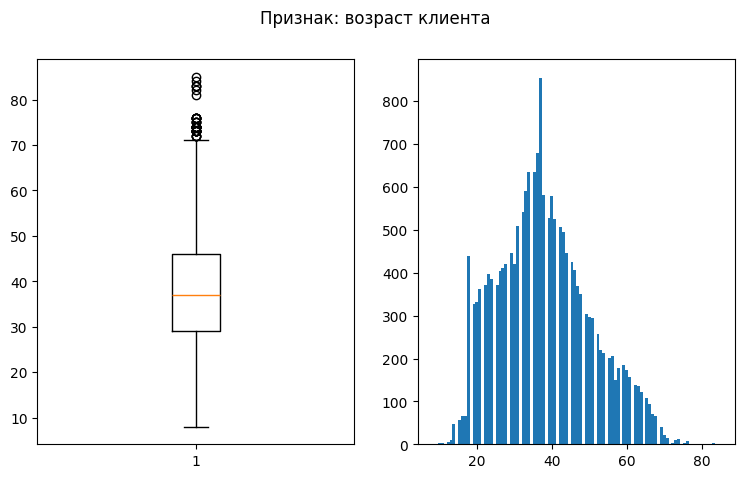

In [44]:
fig = plt.figure(figsize=(9, 5))

plt.subplot(1, 2, 1)
plt.boxplot(x=df['age'])

plt.subplot(1, 2, 2)
plt.hist(df['age'], bins=100)

plt.suptitle('Признак: возраст клиента')
plt.show()

Менее 14 лет - не уверена, что они вообще могут быть клиентами

Более 70 - выбросы

In [45]:
df = df[(df['age'] <= 70) & (df['age'] >= 14)]